# Import Libs

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessing

In [367]:
# Import dataset
data = pd.read_excel('dataset_norm.xlsx')

# Define minimal mark
min_mark = 4

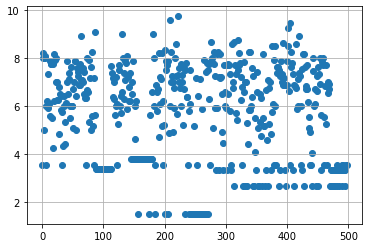

In [368]:
# Output distribution of scores
x = range(len(data['Средний балл']))
y = data['Средний балл']

plt.scatter(x, y)
plt.grid()
plt.show()

NOTE: lines in graph illustrate custom increase the number of not pass students.
That trick were done for better model training. It helps to increase accuracy metricks of models

Lets find out how many students did not pass the exams

In [369]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for mark in data['Средний балл']:
        if mark >= min_mark:
            passed += 1
        elif mark < min_mark:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")

counter_print()

TOTAL: 498
Passed: 341
Not pas: 157


In [370]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop(['Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)

Dataset with concern questions

In [371]:
data.head()

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,Кайнов Кирилл Анатольевич,Нет,"да, хожу на фитнес или в тренажерный зал",От 1 до 3 часов в день,Среднее количество пропусков,1-2 раза в семестр,нет,Нет,0
1,Матутин Василий Андреевич,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,"Нет, но собираюсь в этом году",1
2,Константинов Александр Михайлович,Да,"нет, не занимаюсь",Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,нет,Нет,1
3,Кудакаев Руслан Фаритович,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,Нет,1
4,Балов Илья Сергеевич,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,нет,Да,1


Split our data in 3 parts for train, test and validation

In [372]:
# Save hash of student name
name_hash = []


def train_test_val_split(test_ratio, validation_ratio):
# That part index all names to use them in validation part
    global name_hash
    for idx, name in enumerate(data['Учащийся']):
        name_hash.append((idx, name))
        data.loc[idx:,0] = idx  # data['Учащийся'][idx] = idx


# Replace all text output to index
    label_encoder = LabelEncoder()
    s = (data.dtypes == 'object')
    object_cols = list(s[s].index)
    label_data = data.copy()
    for col in object_cols:
        label_encoder.fit(data[col])
        label_data[col] = label_encoder.transform(data[col])

# Split dataset
# NOTE: To fix split selections use random_state=42 parameter
    size = data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))

    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio)

    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                      y_train, 
                                                      test_size=validation_ratio)

# Output X_train.iloc[:,1:] delete student hash from training and testing selections
    return X_train.iloc[:,1:8], X_test.iloc[:,1:8], X_val.iloc[:,:8], y_train, y_test, y_val

In [373]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.07)

# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [374]:
def classification_quality(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:", (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [375]:
# For historical reason
def regression_quality(y_test, y_pred):
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

In [376]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # Classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for _ in range(4): temp_array.append(None)
    
    # For historical reason
    elif model_flag == 'reg': # Regression
        return
        for _ in range(5): temp_array.append(None)
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for _ in range(len(metrics_list)): temp_array.append(None)

    model_indx = -1
    flag = 1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [377]:
def graph_show(model, X, y):
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)  
    plt.show()

## Classifier

### Perception Classifier Model

In [378]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')

Accuracy: 0.712
Recall: 0.6067125645438898
Precision: 0.6931464174454829
F1: 0.6052631578947367
Weighted Recall: (0.6931464174454829, 0.6067125645438898, 0.6052631578947367, None)


### Random Forest Classifier Model

In [379]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')

Accuracy: 0.992
Recall: 0.9939759036144578
Precision: 0.9883720930232558
F1: 0.9910873440285205
Weighted Recall: (0.9883720930232558, 0.9939759036144578, 0.9910873440285205, None)


### Gradient Boosting Classifier Model

In [380]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 0.976
Recall: 0.9819277108433735
Precision: 0.9666666666666667
F1: 0.9735561667019251
Weighted Recall: (0.9666666666666667, 0.9819277108433735, 0.9735561667019251, None)


### MultinomialNB Classifier Model

In [381]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.792
Recall: 0.7786861732644865
Precision: 0.7673362685745735
F1: 0.7720258136924804
Weighted Recall: (0.7673362685745735, 0.7786861732644865, 0.7720258136924804, None)


### ComplementNB Classifier Model

In [382]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.776
Recall: 0.7666379804934023
Precision: 0.7514880952380952
F1: 0.7569444444444444
Weighted Recall: (0.7514880952380952, 0.7666379804934023, 0.7569444444444444, None)


### GaussianNB Classifier Model

In [383]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.944
Recall: 0.9578313253012047
Precision: 0.9285714285714286
F1: 0.9395258829221094
Weighted Recall: (0.9285714285714286, 0.9578313253012047, 0.9395258829221094, None)


### BernoulliNB Classifier Model

In [384]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.928
Recall: 0.9457831325301205
Precision: 0.9117647058823529
F1: 0.9229504828436408
Weighted Recall: (0.9117647058823529, 0.9457831325301205, 0.9229504828436408, None)


### SVC Classifier Model

In [385]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.936
Recall: 0.9518072289156627
Precision: 0.9199999999999999
F1: 0.9312052834342323
Weighted Recall: (0.9199999999999999, 0.9518072289156627, 0.9312052834342323, None)


### LinearSVC Classifier Model

In [386]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.848
Recall: 0.8208548479632818
Precision: 0.8334824090638044
F1: 0.8265030316312368
Weighted Recall: (0.8334824090638044, 0.8208548479632818, 0.8265030316312368, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### DecisionTreeClassifier Model

In [387]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.984
Recall: 0.9879518072289157
Precision: 0.9772727272727273
F1: 0.982274532047646
Weighted Recall: (0.9772727272727273, 0.9879518072289157, 0.982274532047646, None)


### ExtraTreeClassifier Model

Accuracy: 0.976
Recall: 0.9819277108433735
Precision: 0.9666666666666667
F1: 0.9735561667019251
Weighted Recall: (0.9666666666666667, 0.9819277108433735, 0.9735561667019251, None)


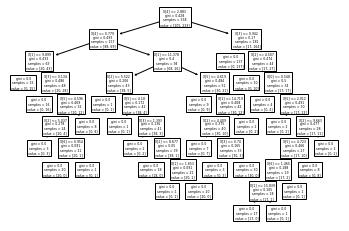

In [388]:
from sklearn.tree import plot_tree, ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

plot_tree(extr)
classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

### MLPClassifier Model

In [389]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.952
Recall: 0.963855421686747
Precision: 0.9375
F1: 0.9479166666666667
Weighted Recall: (0.9375, 0.963855421686747, 0.9479166666666667, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Matrix
That table helps to understand which model is better for my work

In [390]:
pd.DataFrame(index=metrics_list, columns=model_array, data=np.array(pd.DataFrame(output_array).T))

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,BernoulliNB,SVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,MLPClassifier
Accuracy,0.712,0.992,0.976,0.792,0.776,0.944,0.928,0.936,0.848,0.984,0.976,0.952
Balanced Accuracy,0.606713,0.993976,0.981928,0.778686,0.766638,0.957831,0.945783,0.951807,0.820855,0.987952,0.981928,0.963855
Recall,0.606713,0.993976,0.981928,0.778686,0.766638,0.957831,0.945783,0.951807,0.820855,0.987952,0.981928,0.963855
Precision,0.693146,0.988372,0.966667,0.767336,0.751488,0.928571,0.911765,0.92,0.833482,0.977273,0.966667,0.9375
F1,0.605263,0.991087,0.973556,0.772026,0.756944,0.939526,0.92295,0.931205,0.826503,0.982275,0.973556,0.947917
MSE,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None


# Model result

I decided to use model X due to its metrix

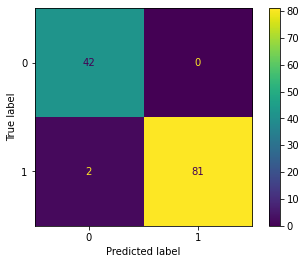

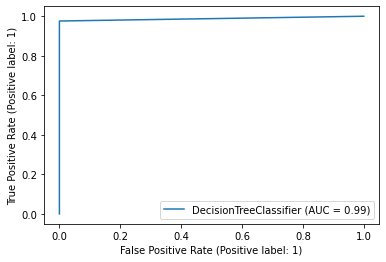

In [391]:
my_model = dtr

# ROC/AUC graphs
graph_show(my_model, X_test, y_test)

# Validation

In [392]:
# Get predicted results of validation selection
# NOTE: Validation selection was not used for training model thus the results are objective
y_pred_val = my_model.predict(X_val.iloc[:,1:])

In [393]:
error_counter = 0
total = 0
for i in range(len(y_pred_val)):
    if y_pred_val[i] != y_val.iloc[i] == 1:
        error_counter += 1
    total += 1
    print(f'Студент {name_hash[X_val.iloc[i, 0]][1]} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')
print(f'There were {error_counter} from {total} error(s)!')

Студент Палашинович Анна Ивановна предположительно не сдал(а), в жизни не сдал(а)
Студент Сехина Анастасия Васильевна предположительно сдал(а), в жизни сдал(а)
Студент Бахметьева-Войникович Тамара Борисовна предположительно сдал(а), в жизни сдал(а)
Студент Бахметьева-Войникович Тамара Борисовна предположительно сдал(а), в жизни сдал(а)
Студент Тихобаев Илья Сергеевич предположительно сдал(а), в жизни сдал(а)
Студент Бабина Анастасия Владимировна предположительно не сдал(а), в жизни не сдал(а)
Студент Королёв Никита Евгеньевич предположительно не сдал(а), в жизни не сдал(а)
Студент Бахметьева-Войникович Тамара Борисовна предположительно сдал(а), в жизни сдал(а)
Студент Мещерин Антон Андреевич предположительно сдал(а), в жизни сдал(а)
Студент Мещерин Антон Андреевич предположительно сдал(а), в жизни сдал(а)
Студент Шулешов Павел Николаевич предположительно сдал(а), в жизни сдал(а)
Студент Лакеев Денис Максимович предположительно не сдал(а), в жизни не сдал(а)
Студент Кашина Елизавета Анд

# Visual

In [394]:
# Replace all text output to index
label_encoder = LabelEncoder()
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
label_data = data.copy()
for col in object_cols:
    label_encoder.fit(data[col])
    label_data[col] = label_encoder.transform(data[col])

rs = np.random.RandomState(0)
corr = label_data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,0
Учащийся,1.000000,-0.086131,-0.032908,-0.096766,-0.086745,0.028320,-0.066216,-0.034154,-0.034537
16.Работаете ли Вы?,-0.086131,1.000000,0.089090,0.076887,-0.039203,-0.037762,-0.065567,-0.041863,-0.034227
14.Увлекаетесь ли Вы спортом?,-0.032908,0.089090,1.000000,-0.101621,-0.177372,0.047282,-0.109349,-0.005452,-0.026653
9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,-0.096766,0.076887,-0.101621,1.000000,0.361126,-0.158651,-0.010636,-0.047685,0.091977
8.Как много Вы пропускаете аудиторных занятий?,-0.086745,-0.039203,-0.177372,0.361126,1.000000,-0.387457,-0.050922,-0.084693,0.126722
6.Бывают ли у Вас долги по экзаменам/зачетам?,0.028320,-0.037762,0.047282,-0.158651,-0.387457,1.000000,0.031436,0.180910,-0.350675
"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",-0.066216,-0.065567,-0.109349,-0.010636,-0.050922,0.031436,1.000000,0.178260,-0.083450
1.Участвуете ли Вы в олимпиадах?,-0.034154,-0.041863,-0.005452,-0.047685,-0.084693,0.180910,0.178260,1.000000,-0.115665
0,-0.034537,-0.034227,-0.026653,0.091977,0.126722,-0.350675,-0.083450,-0.115665,1.000000
